In [1]:
import pandas as pd
import dask.dataframe as dd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [2]:
#orion and FFPE
FF_Fu_dir = "/home/evos/Outputs/CRC/FF/1_extract_histopathological_features/features.txt"
FF_Fu = pd.read_csv(FF_Fu_dir, sep="\t", index_col=0)
#FF_macenko_Fu_dir = "/home/evos/Outputs/CRC/FF_macenko/1_extract_histopathological_features/features.txt"
#FF_macenko_Fu = pd.read_csv(FF_macenko_Fu_dir, sep="\t", index_col=0)
FFPE_Fu_dir = "/home/evos/Outputs/CRC/FFPE/1_extract_histopathological_features/features_format_parquet"
FFPE_Fu_dd = dd.read_parquet(f"{FFPE_Fu_dir}/features-*.parquet")

In [3]:
metadata_columns = ['tile_ID', 'sample_submitter_id', 'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y']  # Replace with actual metadata column names

FF_Fu_features = FF_Fu.drop(columns=metadata_columns)
#FF_macenko_Fu_features = FF_macenko_Fu.drop(columns=metadata_columns)
FFPE_Fu_features_dd = FFPE_Fu_dd.drop(columns=metadata_columns)

FF_rows = FF_Fu.shape[0]
#FF_macenko_rows = FF_macenko_Fu.shape[0]
FFPE_rows = FFPE_Fu_features_dd.shape[0].compute() 

del FF_Fu, FFPE_Fu_dd

In [4]:
orion_Fu_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features/features.txt"
orion_Fu = pd.read_csv(orion_Fu_dir, sep="\t", index_col=0)
#orion_gamma_Fu_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features_gamma/features.txt"
#orion_gamma_Fu = pd.read_csv(orion_gamma_Fu_dir, sep="\t", index_col=0)
orion_macenko_Fu_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features_macenko/features.txt"
orion_macenko_Fu = pd.read_csv(orion_macenko_Fu_dir, sep="\t", index_col=0)

In [5]:
metadata_columns = ['tile_ID', 'sample_submitter_id', 'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y']  # Replace with actual metadata column names

orion_Fu_features = orion_Fu.drop(columns=metadata_columns)
#orion_gamma_Fu_features = orion_gamma_Fu.drop(columns=metadata_columns)
orion_macenko_Fu_features = orion_macenko_Fu.drop(columns=metadata_columns)
 
orion_rows = orion_Fu.shape[0]
#orion_gamma_rows = orion_gamma_Fu.shape[0]
orion_macenko_rows = orion_macenko_Fu.shape[0]

del orion_Fu, orion_macenko_Fu

In [7]:
# Define a target size for subsampling (adjust based on memory limits)
target_size = 50000  # Total rows after subsampling (adjust as needed)

# Calculate subsample sizes proportionally
total_rows = FF_rows + FFPE_rows + orion_rows + orion_macenko_rows

print(FF_rows)
#print(FF_macenko_rows)

FF_sample_size = int((FF_rows / total_rows) * target_size)
#FF_macenko_sample_size = int((FF_macenko_rows / total_rows) * target_size)
FFPE_sample_size = int((FFPE_rows / total_rows) * target_size)
orion_sample_size = int((orion_rows / total_rows) * target_size)
#orion_gamma_sample_size = int((orion_gamma_rows / total_rows) * target_size)
orion_macenko_sample_size = int((orion_macenko_rows / total_rows) * target_size)

# Subsample each dataset
FF_sample = resample(FF_Fu_features, n_samples=FF_sample_size, random_state=42)
#FF_macenko_sample = resample(FF_macenko_Fu_features, n_samples=FF_macenko_sample_size, random_state=42)
FFPE_sample_dd = FFPE_Fu_features_dd.sample(frac=(FFPE_sample_size / FFPE_rows), random_state=42)
FFPE_sample = FFPE_sample_dd.compute()

orion_sample = resample(orion_Fu_features, n_samples=orion_sample_size, random_state=42)
#orion_gamma_sample = resample(orion_gamma_Fu_features, n_samples=orion_gamma_sample_size, random_state=42)
orion_macenko_sample = resample(orion_macenko_Fu_features, n_samples=orion_macenko_sample_size, random_state=42)

# Combine the subsamples
combined_sample = np.vstack([FF_sample, FFPE_sample.values, orion_sample, orion_macenko_sample])

# Create labels
labels_sample = (['FF'] * FF_sample_size +
                 #['FF_Macenko'] * FF_macenko_sample_size +
                 ['FFPE'] * len(FFPE_sample) + 
                 ['Orion'] * orion_sample_size +
                 #['Orion_Gamma'] * orion_gamma_sample_size +
                 ['Orion_Macenko'] * orion_macenko_sample_size
                 )

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_results = pca.fit_transform(combined_sample)


220573


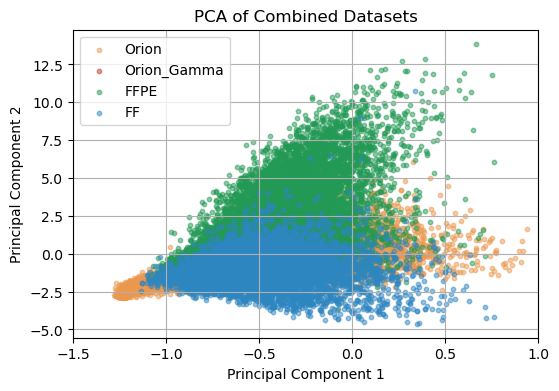

In [7]:
# Define consistent colors for each dataset
color_map = {
    'FF': '#2e86c1',
    'FFPE': '#229954',
    'Orion': '#eb984e',
    'Orion_Gamma': '#c0392b'
}

# Define dataset labels and ensure 'FF' is plotted last
dataset_labels = ['Orion', 'Orion_Gamma', 'FFPE', 'FF']  # Adjust plotting order here

plt.figure(figsize=(6, 4))
for label in dataset_labels:
    idx = [i for i, lbl in enumerate(labels_sample) if lbl == label]
    plt.scatter(pca_results[idx, 0], pca_results[idx, 1],
                label=label, alpha=0.5, s=10, color=color_map[label])

plt.title("PCA of Combined Datasets")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.xlim(-1.5,1)
plt.grid()
plt.show()


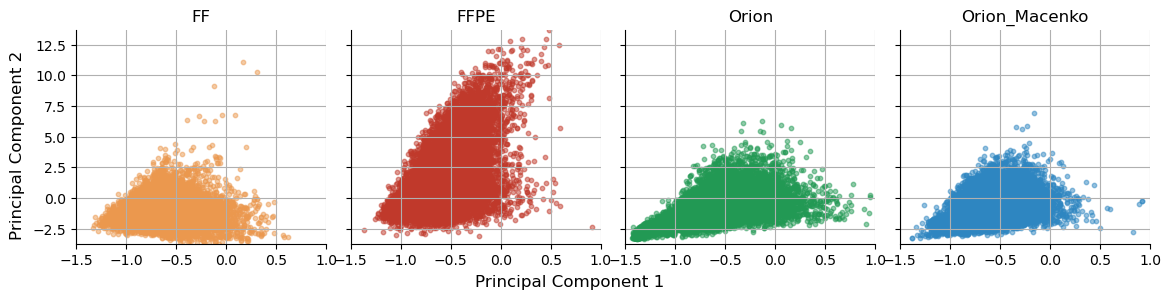

In [15]:
import matplotlib.pyplot as plt
import numpy as np

output_dir_plot = "/home/evos/figures/figures_preproc_scale_features"

# Define color map and dataset labels
color_map = {
    'FF': '#eb984e',
    #'FF_Macenko': '#229954',
    'FFPE': '#c0392b',
    'Orion': '#229954',
    'Orion_Macenko': '#2e86c1'
}

#dataset_labels = ['Orion', 'Orion_Gamma', 'Orion_Macenko', 'FFPE', 'FF']
dataset_labels = ['FF', 'FFPE', 'Orion', 'Orion_Macenko']

# Determine the x and y limits across all datasets
x_min, x_max = np.min(pca_results[:, 0]), np.max(pca_results[:, 0])
y_min, y_max = np.min(pca_results[:, 1]), np.max(pca_results[:, 1])

# Create subplots in a single row
fig, axes = plt.subplots(1, len(dataset_labels), figsize=(12, 3), sharex=True, sharey=True)

# Plot each dataset in its own subplot
for ax, label in zip(axes, dataset_labels):
    idx = [i for i, lbl in enumerate(labels_sample) if lbl == label]
    ax.scatter(pca_results[idx, 0], pca_results[idx, 1],
               label=label, alpha=0.5, s=10, color=color_map[label])
    ax.set_title(label)
    ax.set_xlim(x_min, x_max)
    ax.set_xlim(-1.5,1)
    ax.set_ylim(y_min, y_max)
    ax.grid()
    #ax.legend()
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add common x and y labels
fig.text(0.5, 0.04, "Principal Component 1", ha="center", va="center", fontsize=12)
fig.text(0.04, 0.5, "Principal Component 2", ha="center", va="center", rotation="vertical", fontsize=12)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 1])
plt.savefig(f"{output_dir_plot}/scale_features_Fu.png", dpi=300) 
plt.show()
plt.close()  